In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"
import statsmodels.api as sm

from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import nbimporter
from Functions import getTEvents, get_dollar_bars, get_returns, get_daily_vol, \
                      add_vertical_barrier, get_events_tripple_barrier

## Auxilary Functions

In [2]:
def num_conc_events(closeIdx: np.ndarray, t1: pd.Series, molecule: np.ndarray) -> pd.Series:
    '''
    Computing the number of concurrent events per bar
    
        Parameters:
            closeIdx (np.ndarray): timestamps of close prices
            t1 (pd.Series): series with the timestamps of the vertical barriers
            molecule (np.ndarray): dates of events on which weights are computed
            
        Returns:
            pd.Series with number of labels concurrent at each timestamp
    '''
    t1 = t1.fillna(closeIdx[-1])
    t1 = t1[t1 >= molecule[0]]
    t1 = t1.loc[:t1[molecule].max()]
    iloc = closeIdx.searchsorted(pd.DatetimeIndex([t1.index[0], t1.max()]))
    count = pd.Series([0] * (iloc[1] + 1 - iloc[0]), index=closeIdx[iloc[0]: iloc[1] + 1])
    for tIn, tOut in t1.iteritems():
        count.loc[tIn: tOut] += 1
    return count.loc[molecule[0]: t1[molecule].max()]

In [3]:
def sample_weights(t1: pd.Series, num_conc_events: pd.Series, molecule: np.ndarray) -> pd.Series:
    '''
    Computing average uniqueness over the event's lifespan
    
        Parameters:
            t1 (pd.Series): series with the timestamps of the vertical barriers
            num_conc_events (pd.Series): number of concurrent events per bar
            molecule (np.ndarray): dates of events on which weights are computed
            
        Returns:
            weights (pd.Series): weights that represent the average uniqueness
    '''
    weights = pd.Series([0] * len(molecule), index=molecule)
    for tIn, tOut in t1.loc[weights.index].iteritems():
        weights.loc[tIn] = (1.0 / num_conc_events.loc[tIn: tOut]).mean()
    return weights

In [4]:
def get_ind_matrix(barIdx: np.ndarray, t1: pd.Series) -> pd.DataFrame:
    '''
    Deriving indicator matrix
    
        Parameters:
            barIdx (np.ndarray): indexes of bars
            t1 (pd.Series): series with the timestamps of the vertical barriers
            
        Returns:
            indM (pd.DataFrame): binary matrix indicating what bars influence the label for each observation
    '''
    indM = pd.DataFrame(0, index=barIdx, columns=range(t1.shape[0]))
    for i, (t0, t1) in enumerate(t1.iteritems()):
        indM.loc[t0:t1, i] = 1.0
    return indM


def get_avg_uniqueness(indM: pd.DataFrame) -> float:
    '''
    Compute average uniqueness from indicator matrix
    '''
    c = indM.sum(axis=1)
    u = indM.div(c, axis=0)
    avg_uniq = u[u > 0].mean()
    return avg_uniq


def seq_bootstrap(indM: pd.DataFrame, sLength: int = None) -> np.ndarray:
    '''
    Generate a sample via sequential bootstrap
    
        Parameters:
            indM (pd.DataFrame): binary matrix indicating what bars influence the label for each observation
            sLength (int) (optional): sample length (if None, equals number of columns in indM)
            
        Returns:
            phi (np.ndarray): array with indexes of the features sampled by sequential bootstrap
    '''
    if sLength is None:
        sLength = indM.shape[1]
    phi = []
    while len(phi) < sLength:
        avg_uniq = pd.Series()
        for i in indM:
            indM_ = indM[phi + [i]]
            avg_uniq.loc[i] = get_avg_uniqueness(indM_).iloc[-1]
        prob = avg_uniq / avg_uniq.sum()
        phi += [np.random.choice(indM.columns, p=prob)]
    return np.array(phi)

Monte Carlo experiments:

In [5]:
def gen_rand_t1(numObs: int, numBars: int, maxH: int) -> pd.Series:
    '''
    Generate random t1 series
    
        Parameters:
            numObs (int): number of observations for which t1 is generated
            numBars (int): number of bars
            maxH (int): upper bound for uniform distribution to determine the number of bars spanned by observation
        Returns:
            t1 (pd.Series)
    '''
    t1 = pd.Series()
    for i in range(numObs):
        idx = np.random.randint(0, numBars)
        val = idx + np.random.randint(1, maxH)
        t1.loc[idx] = val
    return t1.sort_index()


def aux_MC(numObs: int, numBars: int, maxH: int) -> dict:
    '''
    Generate random t1 series
    
        Parameters:
            numObs (int): number of observations for which t1 is generated
            numBars (int): number of bars
            maxH (int): upper bound for uniform distribution to determine the number of bars spanned by observation
        Returns:
            dict with average uniqueness derived by standard and sequential bootstrap algorithms
    '''
    t1 = gen_rand_t1(numObs, numBars, maxH)
    barIdx = range(t1.max() + 1)
    indM = get_ind_matrix(barIdx, t1)
    phi = np.random.choice(indM.columns, size=indM.shape[1])
    stdU = get_avg_uniqueness(indM[phi]).mean()
    phi = seq_bootstrap(indM)
    seqU = get_avg_uniqueness(indM[phi]).mean()
    return {'stdU': stdU, 'seqU': seqU}


def main_MC(numObs: int, numBars: int, maxH: int, numIters: int) -> None:
    '''
    Run MC simulation for comparing standard and sequential bootstraps
    
        Parameters:
            numObs (int): number of observations for which t1 is generated
            numBars (int): number of bars
            maxH (int): upper bound for uniform distribution to determine the number of bars spanned by observation
            numIters (int): number of MC iterations
        Returns:
            out (pd.DataFrame): dataframe containing uniqueness obtained by standard and sequential bootstraps
    '''
    out = pd.DataFrame()
    for i in range(numIters):
        out = pd.concat((out, pd.DataFrame([aux_MC(numObs, numBars, maxH)])))
    return out

In [6]:
def sample_return_weights(
    t1: pd.Series, num_conc_events: pd.Series, close: pd.Series, molecule: np.ndarray
) -> pd.Series:
    '''
     Determination of sample weights by absolute return distribution
    
        Parameters:
            t1 (pd.Series): series with the timestamps of the vertical barriers
            num_conc_events (pd.Series): number of concurrent events per bar
            close (pd.Series): close prices
            molecule (np.ndarray): dates of events on which weights are computed
            
        Returns:
            weights (pd.Series): weights that absolute returns
    '''
    ret = np.log(close).diff()
    weights = pd.Series(index=molecule, dtype=object)
    for tIn, tOut in t1.loc[weights.index].iteritems():
        weights.loc[tIn] = (ret.loc[tIn: tOut] / num_conc_events.loc[tIn: tOut]).sum()
    return weights.abs()

In [7]:
def get_time_decay(tW: pd.Series, clfLastW: float = 1.0) -> pd.Series:
    '''
    Apply piecewise-linear decay to observed uniqueness. Newest observation gets weight=1,
    oldest observation gets weight=clfLastW.
    
        Parameters:
            tW (pd.Series): observed uniqueness
            clfLastW (float): weight for the oldest observation
        
        Returns:
            clfW (pd.Series): series with time-decay factors
    '''
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0:
        slope = (1.0 - clfLastW) / clfW.iloc[-1]
    else:
        slope = 1. / ((clfLastW + 1) * clfW.iloc[-1])
    const = 1.0 - slope * clfW.iloc[-1]
    clfW = const + slope * clfW
    clfW[clfW < 0] = 0
    # print(const, slope)
    return clfW

## Exercises

Here I use the clean dataset generated in `Chapter2.ipynb`. All the necessary functions implemented in that file are imported here.

In [8]:
data = pd.read_csv('sp10-19.csv')
data.head()

,price,volume,datetime
0,1113.2,1,2010-01-03 17:00:00
1,1113.2,1,2010-01-03 17:00:00
2,1113.2,1,2010-01-03 17:00:00
3,1113.2,1,2010-01-03 17:00:00
4,1113.2,1,2010-01-03 17:00:00


### 1. Overlapping Outcomes & Concurrent Labels

First we need to compute `t1` series on dollar bars. We again use average daily volatility as return threshold.

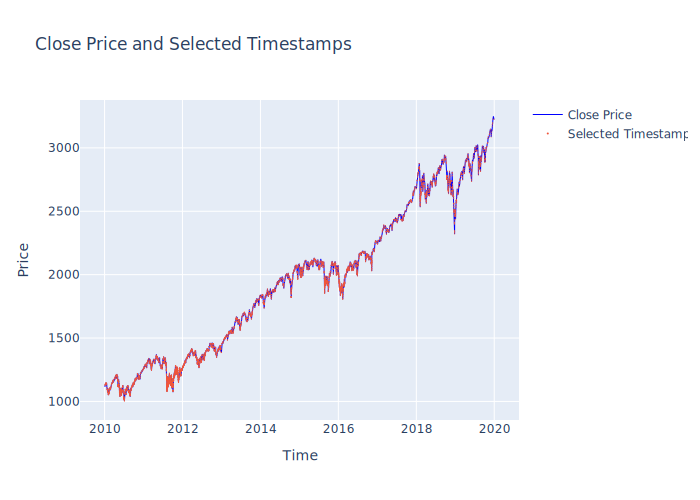

In [9]:
# $50,000 per bar
dollar_bars = get_dollar_bars(data['price'].values, data['volume'].values, data['datetime'].values, 50000)
dollar_bars_df = pd.DataFrame(data=dollar_bars[:, 1:], index=dollar_bars[:, 0],
                           columns=['open', 'high', 'low', 'close', 'volume'])
dollar_bars_df = dollar_bars_df[~dollar_bars_df.index.duplicated(keep='first')]

mean_std = get_daily_vol(dollar_bars_df['close']).mean()
dollar_ret = get_returns(dollar_bars)

tEvents = getTEvents(dollar_ret, h=mean_std)
chosen_bars_df = dollar_bars_df.loc[tEvents, :]

fig = go.Figure(
    go.Scatter(x=dollar_bars_df.index, y=dollar_bars_df['close'],
               line=dict(color="blue", width=1), name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price and Selected Timestamps")
fig.add_trace(go.Scatter(
    x=chosen_bars_df.index, y=chosen_bars_df['close'], mode='markers', marker=dict(size=1), name='Selected Timestamps'
    )
)
fig.show()

In [10]:
t1 = add_vertical_barrier(dollar_bars_df['close'], tEvents, numDays=1)
events = get_events_tripple_barrier(close=dollar_bars_df['close'], tEvents=tEvents, pt_sl=[1, 1],
                                    trgt=get_daily_vol(dollar_bars_df['close']), minRet=0.007,
                                    numThreads=1, t1=t1)
events

,t1,trgt
2010-01-21 15:41:16.000,2010-01-24 17:26:29.000,0.007767
2010-01-28 17:01:37.000,2010-01-31 17:00:05.000,0.009008
2010-01-28 21:22:56.000,2010-01-31 17:00:05.000,0.013672
2010-01-28 22:25:49.000,2010-01-31 17:00:05.000,0.013559
2010-01-29 00:24:20.000,2010-01-29 07:32:32.000,0.012875
...,...,...
2019-12-13 06:58:48.329,2019-12-17 07:25:09.155,0.008966
2019-12-17 07:25:09.155,2019-12-18 08:11:34.083,0.008693
2019-12-17 07:48:29.219,2019-12-18 08:11:34.083,0.008380
2019-12-20 08:11:47.600,2019-12-24 07:26:30.124,0.007784


Now we apply the function `num_conc_events` to compute the number of overlapping outcomes at each point in time:

In [11]:
num_conc = num_conc_events(closeIdx=dollar_bars_df.index, t1=events['t1'], molecule=events.index)
num_conc

2010-01-21 15:41:16.000    1
2010-01-21 15:47:20.000    1
2010-01-21 17:05:01.000    1
2010-01-21 18:02:14.000    1
2010-01-21 18:11:38.000    1
                          ..
2019-12-17 07:48:29.219    2
2019-12-18 08:11:34.083    2
2019-12-20 08:11:47.600    1
2019-12-24 07:26:30.124    1
2019-12-30 08:08:53.765    1
Length: 80032, dtype: int64

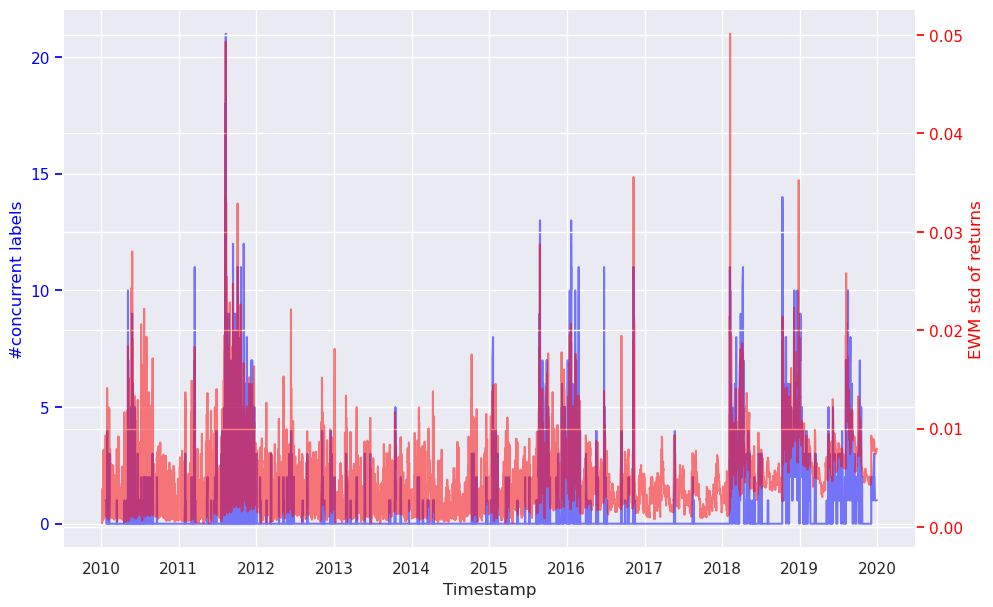

In [12]:
fig, ax = plt.subplots(figsize=(11, 7))
ax2 = ax.twinx()
ax.plot(num_conc, color='blue', alpha=0.5) 
ax2.plot(get_daily_vol(dollar_bars_df['close']), color='red', alpha=0.5)
ax.set_xlabel('Timestamp')
ax.set_ylabel('#concurrent labels', color='blue')
ax.tick_params(axis='y', color='blue', labelcolor='blue')
ax2.set_ylabel('EWM std of returns', color='red')
ax2.tick_params(axis='y', color='red', labelcolor='red')
plt.show()

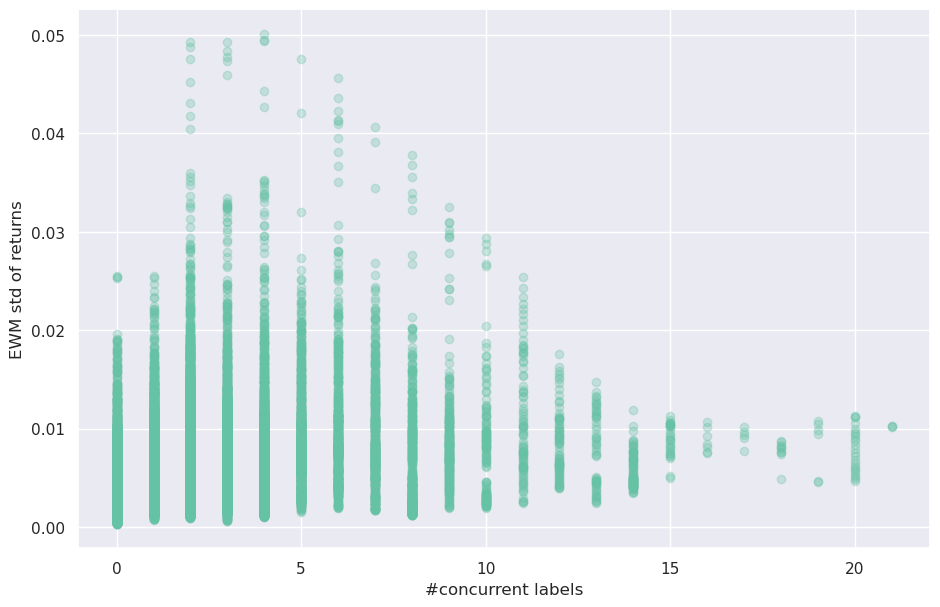

In [13]:
fig, ax = plt.subplots(figsize=(11, 7))
ind = set(num_conc.index).intersection(set(get_daily_vol(dollar_bars_df['close']).index))
ax.scatter(num_conc[ind], get_daily_vol(dollar_bars_df['close'])[ind], alpha=0.3)
ax.set_xlabel('#concurrent labels')
ax.set_ylabel('EWM std of returns')
plt.show()

### 2. Average Uniqueness of Each Label

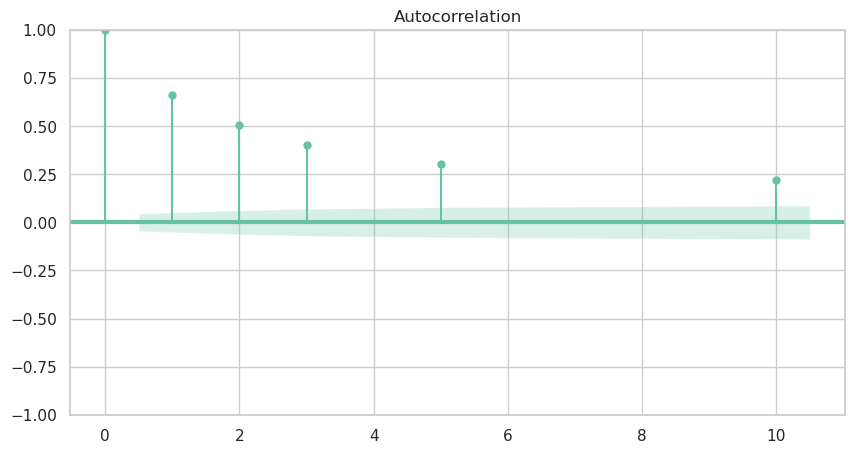

In [14]:
avg_uniq = sample_weights(t1=events['t1'], num_conc_events=num_conc, molecule=events.index)

rcParams['figure.figsize'] = 10, 5
with sns.axes_style('whitegrid'):
    sm.graphics.tsa.plot_acf(avg_uniq[:-1], lags=[0, 1, 2, 3, 5, 10], lw=3)

First-order serial correlation of the average uniqueness series appears to be statistically significant, as do some other higher-order correlations.

### 3. Random Forest, OOB&CV accuracy

Let's train random forest on some artificial financial dataset. We will use current and previous close prices along with current volatility to predict whether the next close price will be higher or lower.

In [15]:
ind = get_daily_vol(dollar_bars_df['close']).index
data = pd.DataFrame({'close current': dollar_bars_df['close'][ind].values,
                     'close previous': dollar_bars_df['close'].shift(1)[ind].values,
                     'vol current': get_daily_vol(dollar_bars_df['close']).values,
                     'close next': dollar_bars_df['close'].shift(-1)[ind].values}).dropna()
X = data.drop('close current', axis=1)
y = (data['close next'] > data['close current']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestClassifier(n_estimators=25, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, n_jobs=-1, oob_score=True)

In [16]:
print(f'RF OOB accuracy: {rf.oob_score_}')

RF OOB accuracy: 0.6241253328379466


Now let's calculate the mean cross validation accuracy on the same dataset:

In [17]:
accuracies = cross_val_score(rf, X, y, cv=5)
print(f'RF mean cross validation accuracy: {accuracies.mean()}')

RF mean cross validation accuracy: 0.5574834355068425


We can notice that the CV score is significantly lower than the out-of-bag score. This is due to the incorrect assumption of IID samples that decision trees are trained on. In our case this implies that the trees in the random forest are not different enough and the CV accuracy estimation is a less biased estimation.